In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F
from PIL import Image
import numpy as np
import os
from copy import copy
import matplotlib

# Make torch dataset with YOLO labels
We have a simple dataset with images and bounding boxes for four 
types of animal:
* buffalo
* elephant
* rhino
* zebra
<br>
In our instance, YOLO has the following format:
output [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24]

In [ ]:
#utility functions for creating labels

PATH='/Users/ben/Downloads/archive'

def wide_or_tall(bbox):
    # wide or tall bbox
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    if abs(x1-x2)>abs(y1-y2):
        return 'wide'
    else:
        return 'tall'

def probs(classname):
    #return C,p1,p2,p3,p4 subarr given object exists
    if classname=='buffalo':
        return [1,1,0,0,0]
    elif classname=='elephant':
        return [1,0,1,0,0]
    elif classname=='rhino':
        return [1,0,0,1,0]
    elif classname=="zebra":
        return [1,0,0,0,1]
    else:
        raise ValueError("Class name invalid: ",classname)

# now we make our labels in [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24] format
# say first bbox prediction wide, second bbox prediction tall

def make_labels(path):
    #read dataset labels into dictionary
    labels={}
    os.chdir(path)
    animals=['buffalo','elephant','rhino','zebra']
    for i,animal in enumerate(animals):
        for file in os.listdir(f'{path}/{animal}'):
            if '.txt' in file:
                classname = i
                f = open(f'{animal}/{file}')
                label = f.readlines()
                label = [l.replace('\n','') for l in label][0].split(' ')
                label = [float(l) for l in label]
                bbox = label[1:]
                bbox_type = wide_or_tall(bbox)
                if bbox_type=='wide':
                    result_left = np.concatenate([bbox,probs(animal)])
                    result = np.concatenate([result_left,np.zeros([9,])])
                elif bbox_type=='tall':
                    result_right = np.concatenate([bbox,probs(animal)])
                    result = np.concatenate([np.zeros([9,]),result_right])
                labels[f'{animal}/{file}']=result
    return labels

labels = make_labels(PATH)
print(len(labels))

In [247]:
# let's make our own torch dataset type...
# as we have custom labels
# inherits torch.utils.data.Dataset
class YOLODataset(Dataset):
    """YOLO dataset."""

    def __init__(self, path=PATH, transform=None):
        """
        Args:
            path: path to the dataset root folder, 
            default set by global var
        """
        self.path = path
        self.labels = make_labels(self.path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fname = list(self.labels.keys())[idx]
        
        label = self.labels[fname]
        img_name=f"{self.path}/{fname}"
        img_name=img_name.replace('.txt','.jpg')
        with Image.open(img_name) as im:
            im = np.asarray(im)
            shape = im.shape
            #gotta reshape h,w,c -> c,h,w for torch
            im = im.reshape([3,shape[0],shape[1]])
            sample = {'image': np.asarray(im), 'label': label}
        return sample
    
    def __showbbox__(self,idx):
        # return image with drawn bbox
        if torch.is_tensor(idx):
            idx = idx.tolist()
        res = self.__getitem__(idx)
        img = res['image']
        shape = img.shape
        img = img.reshape([shape[1],shape[2],3])
        plt.imshow(img)
        width=img.shape[0]
        height=img.shape[1]
        label = res['label']
        # wide bbox on left, tall on right
        widebbox = label[0:9]
        tallbbox = label[9:]
        if(widebbox.sum()!=0):
            x=widebbox[0]*width
            y=widebbox[1]*height
            w=widebbox[2]*width
            h=widebbox[3]*height
            print(x,y,w,h)
        else:
            print(tallbbox)

1504
(3, 427, 640)
205.49375 419.67232 300.234375 380.70272


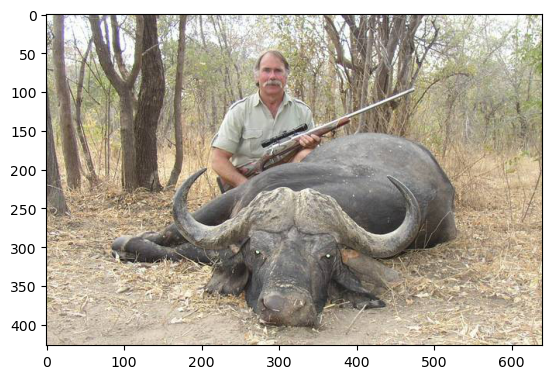

In [248]:
ds = YOLODataset()
print(ds.__len__())
print(ds.__getitem__(200)['image'].shape)
ds.__showbbox__(200)
# need to write custom collate function to prevent 
# torch stacking different size input images
train_dataloader = DataLoader(ds, batch_size=1,
                        shuffle=True)

In [ ]:
# Get gpu device for training if available otherwise use cpu
device = "mps"
print(f"Using {device} device")

# darknet conv function adapted from Darknet53 implementation
# https://github.com/developer0hye/PyTorch-Darknet53/blob/master/model.py

def dark_conv(c_in, c_out, kernel=1, stride=1, padding=0):
    """
    Construct a convolutional block function 
    given the input dimensions
    c_in: channels in
    c_out: channels out
    kernel: filter / convolution size (is square)
    stride: convolution stride 
    padding: convolution padding 

    Based on DarkNet19 configuration
    """
    return nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel, stride, padding),
            nn.BatchNorm2d(c_out),
            nn.ReLU())

# Our CNN model
class DarkNet19(nn.Module):
    def __init__(self):
        super(DarkNet19, self).__init__()
        self.c1 = dark_conv(3, 32, 3)
        self.c2 = dark_conv(32, 64, 3)
        self.c3 = dark_conv(64, 128, 3)
        self.c4 = dark_conv(128, 64, 1)
        self.c5 = dark_conv(64, 128, 3)
        self.c6 = dark_conv(128, 256, 3)
        self.c7 = dark_conv(256, 128, 1)
        self.c8 = dark_conv(128, 256, 3)
        self.c9 = dark_conv(256, 512, 3)
        self.c10 = dark_conv(512, 256, 1)
        self.c11 = dark_conv(256, 512, 3)
        self.c12 = dark_conv(512, 256, 1)
        self.c13 = dark_conv(256, 512, 3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # output [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24]
        self.fc = nn.Linear(512,18)

    def forward(self, x):
        # feature extraction
        x = self.c1(x)
        x = F.max_pool2d(x,2,2)
        x = self.c2(x)
        x = F.max_pool2d(x,2,2)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = F.max_pool2d(x,2,2)
        x = self.c6(x)
        x = self.c7(x)
        x = self.c8(x)
        x = F.max_pool2d(x,2,2)
        x = self.c9(x)
        x = self.c10(x)
        x = self.c11(x)
        x = self.c12(x)
        x = self.c13(x)
        # head
        x = self.global_avg_pool(x)
        x = x.view(-1, 512)
        output = self.fc(x)
        return output

#declare CNN model instance
model = DarkNet19().to(device)
print("Neural Network PyTorch Architecture:")
print(model)

#define loss function and optimizer
#MSE loss for now until we define actual YOLO loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Function to train CNN model
    """
    size = len(dataloader.dataset)
    model.train()
    history = []
    total_correct = 0
    total_done = 0
    count = 0
    for batch, data in enumerate(dataloader):
        image = torch.tensor(data['image'])
        #remove alpha channel
        image = image.to(torch.float32).to(device)
        label = torch.tensor(data['label'])
        label = label.to(torch.float32).to(device)

        # Compute prediction error
        preds = model(image)
        loss = loss_fn(preds, label)
        print(preds,label)

        # Backpropagation block
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

    #average accuracy over training set during training
    acc = total_correct / total_done
    return acc, history

Train and plot guesses

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
Interrupt when you see the validation accuracy plataeu 
We then load the best model weights (by validation accuracy)
and we can run inference with them
"""
#load best previous model
try:
    model = torch.load('best-model.pt')
except:
    print("No previous model.")

#train
epochs = 10
train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, t_loss = train(train_dataloader, model, loss_fn, optimizer)
    print(f"acc: {t_acc} loss: {t_loss}")
    train_accs.append(t_acc)
    train_losses.append(t_loss)
print("Done!")